In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score
import sklearn.decomposition

# Reading Data

In [2]:
df_chunk = pd.read_csv('accepted_2007_to_2018Q4.csv', chunksize=1000000)

chunk_list = []

for chunk in df_chunk:
    chunk_list.append(chunk)
    

C:\Users\Jorge\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Jorge\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Jorge\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_concat = pd.concat(chunk_list)

# Exploratory Data Analysis

## Data Frame

In [4]:
df_concat.shape

(2260701, 151)

In [5]:
pd.options.display.max_columns = None

df_concat.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [6]:
# Checking the categories for loan status

df_concat.groupby('loan_status').count()[['id']]

,id
loan_status,
Charged Off,268559
Current,878317
Default,40
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,1076751
In Grace Period,8436
Late (16-30 days),4349
Late (31-120 days),21467


In [7]:
# Removing anything that isnt 'Default', or any variation of 'Charged off' or 'Fully Paid' then checking the shape

loan = df_concat[(df_concat['loan_status'] == 'Fully Paid') | (df_concat['loan_status'] == 'Default')|(df_concat['loan_status'] == 'Charged Off')|(df_concat['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')]

loan.shape


(1346111, 151)

In [8]:
# Adding a new column with a binary for delinquent or fully paid

loan.loc[loan['loan_status']== 'Fully Paid', 'result'] = 'Fully Paid'
loan.loc[loan['loan_status']!= 'Fully Paid', 'result'] = 'Delinquent'

loan.head()

C:\Users\Jorge\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Jorge\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,result
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,N

In [9]:
loan.groupby('result').count()[['id']]

,id
result,
Delinquent,269360
Fully Paid,1076751


In [10]:
loan.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1346111 entries, 0 to 2260697
Data columns (total 152 columns):
id                                            1346111 non-null object
member_id                                     0 non-null float64
loan_amnt                                     1346111 non-null float64
funded_amnt                                   1346111 non-null float64
funded_amnt_inv                               1346111 non-null float64
term                                          1346111 non-null object
int_rate                                      1346111 non-null float64
installment                                   1346111 non-null float64
grade                                         1346111 non-null object
sub_grade                                     1346111 non-null object
emp_title                                     1260270 non-null object
emp_length                                    1267580 non-null object
home_ownership                                

## Feature Exploration

### Loan Amount

In [11]:
loan['loan_amnt'].describe()

count    1.346111e+06
mean     1.441720e+04
std      8.716739e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

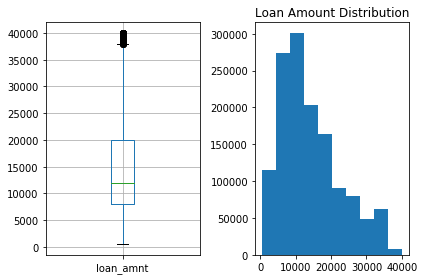

In [12]:
plt.subplot(1, 2, 1)
loan.boxplot(column='loan_amnt')

plt.subplot(1, 2, 2)
plt.hist(loan['loan_amnt'])
plt.title('Loan Amount Distribution')

plt.rcParams['figure.figsize'] = (10,10)
plt.tight_layout()
plt.show()

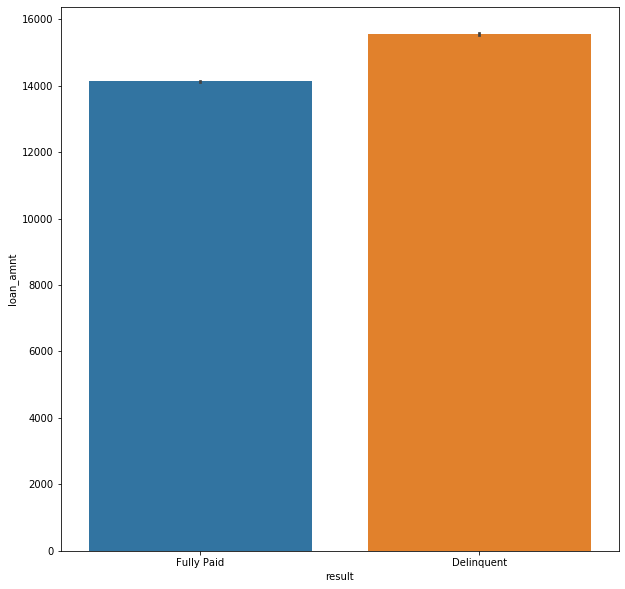

In [13]:
sns.barplot(x="result", y="loan_amnt", data=loan)

### Term

In [14]:
loan.groupby('term').count()[['id']]

,id
term,
36 months,1021417
60 months,324694


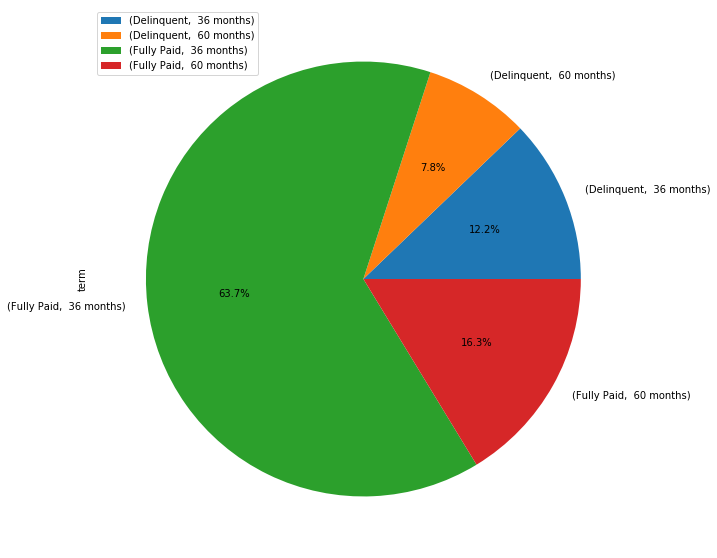

In [15]:
loan['term'].groupby(loan['result']).value_counts().plot(kind='pie',autopct='%1.1f%%', legend=True)
plt.rcParams['figure.figsize'] = (10,10)


### Annual Income

In [16]:
loan['annual_inc'].describe()

count    1.346111e+06
mean     7.624377e+04
std      6.992085e+04
min      0.000000e+00
25%      4.576000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

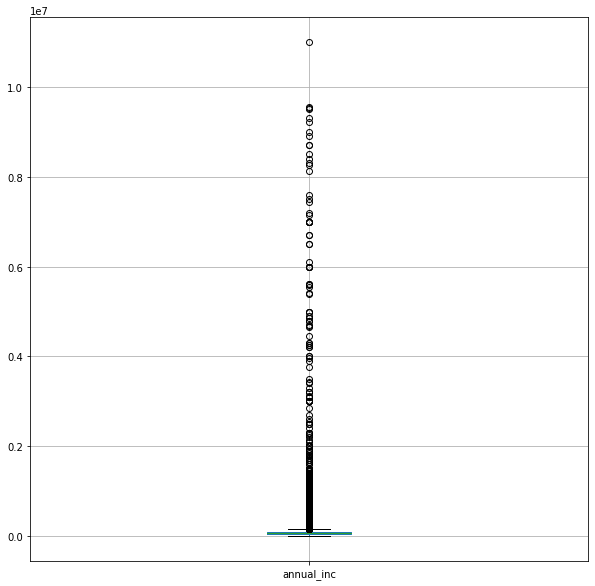

In [17]:
loan.boxplot(column='annual_inc')


plt.show()

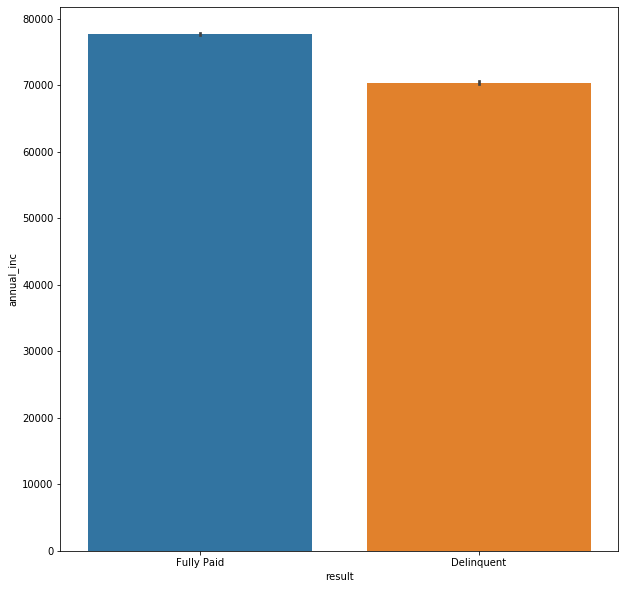

In [18]:
sns.barplot(x="result", y="annual_inc", data=loan)

### Application Type

In [19]:
loan.groupby('application_type').count()[['id']]


,id
application_type,
Individual,1320305
Joint App,25806


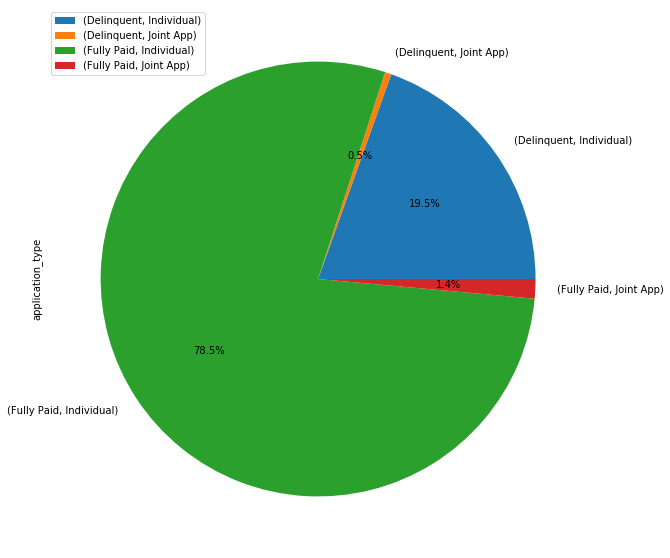

In [20]:
loan['application_type'].groupby(loan['result']).value_counts().plot(kind='pie',autopct='%1.1f%%', legend=True)

### Loan Status

In [21]:
loan.groupby('loan_status').count()[['id']]

,id
loan_status,
Charged Off,268559
Default,40
Does not meet the credit policy. Status:Charged Off,761
Fully Paid,1076751


# Statistical Analysis

In [22]:
# This function will create a replicate of the data

def bs_replicate_1d(data, func, **kwargs):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample, **kwargs)

In [23]:
# This function will find the difference between the means of 2 groups of data

def mean_diff(x0, x1):
    m0 = bs_replicate_1d(x0, np.mean)
    m1 = bs_replicate_1d(x1, np.mean)
    return m0 - m1

## Bootstraping analysis for loan amount mean

In [24]:
# Making loan amount series by grouping data into delinquent or fully paid 

fully_paid_loan_amnt =loan.loan_amnt[loan.result == 'Fully Paid'] 
delinquent_loan_amnt =loan.loan_amnt[loan.result != 'Fully Paid']


In [25]:
# finding mean difference of the replicates 1000 times

mean_diffs = [mean_diff(fully_paid_loan_amnt, delinquent_loan_amnt) for i in np.arange(1000)]

mean_diff_pc = np.percentile(mean_diffs, [2.5, 97.5])
mean_diff_pc

array([-1445.86861905, -1377.15537548])

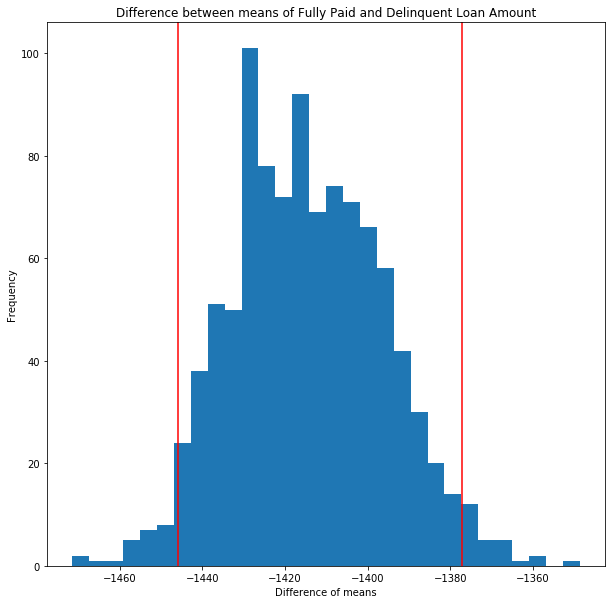

In [26]:
_ = plt.hist(mean_diffs, bins=30)
_ = plt.axvline(x=mean_diff_pc[0], color='r')
_ = plt.axvline(x=mean_diff_pc[1], color='r')
_ = plt.xlabel('Difference of means')
_ = plt.ylabel('Frequency')
_ = plt.title('Difference between means of Fully Paid and Delinquent Loan Amount')
plt.show()

## Bootstraping analysis for annual income  mean

In [27]:
# Making annual income series by grouping data into delinquent or fully paid 

fully_paid_annual_inc =loan.annual_inc[loan.result == 'Fully Paid'] 
delinquent_annual_inc =loan.annual_inc[loan.result != 'Fully Paid']

In [28]:
# finding mean difference of the replicates 1000 times

mean_diffs2 = [mean_diff(fully_paid_annual_inc, delinquent_annual_inc) for i in np.arange(1000)]

mean_diff2_pc = np.percentile(mean_diffs2, [2.5, 97.5])
mean_diff2_pc

array([7027.93689182, 7566.51640902])

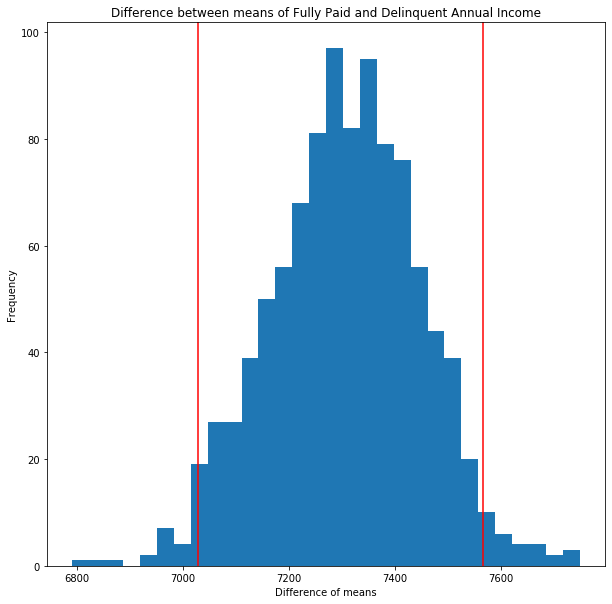

In [29]:
_ = plt.hist(mean_diffs2, bins=30)
_ = plt.axvline(x=mean_diff2_pc[0], color='r')
_ = plt.axvline(x=mean_diff2_pc[1], color='r')
_ = plt.xlabel('Difference of means')
_ = plt.ylabel('Frequency')
_ = plt.title('Difference between means of Fully Paid and Delinquent Annual Income')
plt.show()

# Machine Learning

In [30]:
# making a a column for 0,1 binary target variable

loan.loc[loan['result']== 'Fully Paid', 'result_binary'] = 0
loan.loc[loan['result']!= 'Fully Paid', 'result_binary'] = 1


C:\Users\Jorge\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Jorge\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Test 1:  Basic Random Forest Model

In [31]:
loan_t1= loan[['annual_inc', 'loan_amnt', 'application_type','term']]
loan_t1_cat = pd.get_dummies(loan_t1, drop_first=True)


X= loan_t1_cat.values
y= loan['result_binary'].values



X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

rf_class= RandomForestClassifier(random_state=42)
rf_class.fit(X_train, y_train.ravel())

y_pred = rf_class.predict(X_test)

y_pred_proba = rf_class.predict_proba(X_test)[:,1]


In [84]:
roc_auc_score(y_test, y_pred_proba)

0.5956456737692993

## Test 2: Random Forest Model with PCA

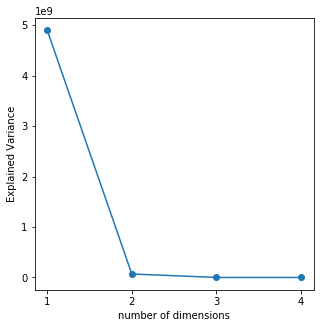

In [55]:
# Creating elbow plot to find best value for k

arrx= np.array(X)

pca = sklearn.decomposition.PCA()
pca.fit(arrx)

dims=np.arange(1,5)

plt.plot(dims, pca.explained_variance_, '-o')
plt.rcParams['figure.figsize'] = (5,5)
plt.xlabel('number of dimensions')
plt.ylabel('Explained Variance')
plt.xticks(dims)
plt.show()

In [72]:
# Creating PCA transformation with k=2

PCA_model = sklearn.decomposition.PCA(n_components=2)
PCA_features = PCA_model.fit_transform(X)

In [75]:
# testing 

X2_train, X2_test, y2_train, y2_test= train_test_split(PCA_features,y, test_size=0.2, random_state=42)

rf_class2= RandomForestClassifier(random_state=42)
rf_class2.fit(X2_train, y2_train.ravel())

y2_pred = rf_class2.predict(X2_test)

y2_pred_proba = rf_class2.predict_proba(X2_test)[:,1]
roc_auc_score(y2_test, y2_pred_proba)

0.5706284682192733

## Test 3: Random Forest Model with tuned n_estimators parameter

In [86]:
parameters = [{'n_estimators': [10,20,50,100]}]

grid_search = GridSearchCV(estimator = rf_class, param_grid = parameters, scoring = 'roc_auc', cv=5)

grid_search = grid_search.fit(X_train, y_train) 

roc_auc_t3 = grid_search.best_score_
roc_auc_t3

0.5943204133166218

In [87]:
grid_search.best_params_

{'n_estimators': 100}

## Test 4: Gradiant Boosted Model

In [91]:
gb_class= GradientBoostingClassifier(random_state=42)
gb_class.fit(X_train, y_train.ravel())

parameters_gb = [{'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]}]

grid_search_gb = GridSearchCV(estimator = gb_class, param_grid = parameters_gb, scoring = 'roc_auc', cv=5)

grid_search_gb = grid_search_gb.fit(X_train, y_train)

roc_auc_t4 = grid_search_gb.best_score_
roc_auc_t4

0.6443110963711426

In [92]:
grid_search_gb.best_params_

{'learning_rate': 0.5}